# Survival Analysis Playground

This notebook provides a playground for experimenting with survival analysis models using the `lifelines` package.

## Features:
- Load datasets using lifelines
- Run survival analysis models (CoxPH, Kaplan-Meier, etc.)
- Visualize survival curves and model results


In [50]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lifelines for survival analysis
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.datasets import load_gbsg2, load_recur
from sklearn.preprocessing import StandardScaler

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## 1. Loading Datasets

Lifelines provides several built-in datasets. Here are some common ones:


In [51]:
# Load a dataset (example: Waltons dataset - fruit fly survival)
# You can switch to other datasets: load_rossi(), load_dd(), load_regression_dataset()
df = load_gbsg2()

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:", df.columns.tolist())
print("\nDataset info:")
print(df.info())


Dataset shape: (686, 10)

First few rows:
  horTh  age menostat  tsize tgrade  pnodes  progrec  estrec  time  cens
0    no   70     Post     21     II       3       48      66  1814     1
1   yes   56     Post     12     II       7       61      77  2018     1
2   yes   58     Post     35     II       9       52     271   712     1
3   yes   59     Post     17     II       4       60      29  1807     1
4    no   73     Post     35     II       1       26      65   772     1

Column names: ['horTh', 'age', 'menostat', 'tsize', 'tgrade', 'pnodes', 'progrec', 'estrec', 'time', 'cens']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   horTh     686 non-null    object
 1   age       686 non-null    int64 
 2   menostat  686 non-null    object
 3   tsize     686 non-null    int64 
 4   tgrade    686 non-null    object
 5   pnodes    686 non-n

In [52]:
df.head()

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


## 2. Exploratory Data Analysis


In [53]:
# Basic statistics
print("Summary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Summary statistics:
              age       tsize      pnodes      progrec       estrec  \
count  686.000000  686.000000  686.000000   686.000000   686.000000   
mean    53.052478   29.329446    5.010204   109.995627    96.252187   
std     10.120739   14.296217    5.475483   202.331552   153.083963   
min     21.000000    3.000000    1.000000     0.000000     0.000000   
25%     46.000000   20.000000    1.000000     7.000000     8.000000   
50%     53.000000   25.000000    3.000000    32.500000    36.000000   
75%     61.000000   35.000000    7.000000   131.750000   114.000000   
max     80.000000  120.000000   51.000000  2380.000000  1144.000000   

              time        cens  
count   686.000000  686.000000  
mean   1124.489796    0.435860  
std     642.791948    0.496231  
min       8.000000    0.000000  
25%     567.750000    0.000000  
50%    1084.000000    0.000000  
75%    1684.750000    1.000000  
max    2659.000000    1.000000  

Missing values:
horTh       0
age         

## 3. Kaplan-Meier Estimator (Non-parametric)

The Kaplan-Meier estimator is a non-parametric method to estimate survival probabilities.


In [54]:
df.cens.unique()

array([1, 0])

In [55]:
df['event'] = 1 - df['cens']
df.event.unique()

array([0, 1])

Using time column: time
Using event column: event


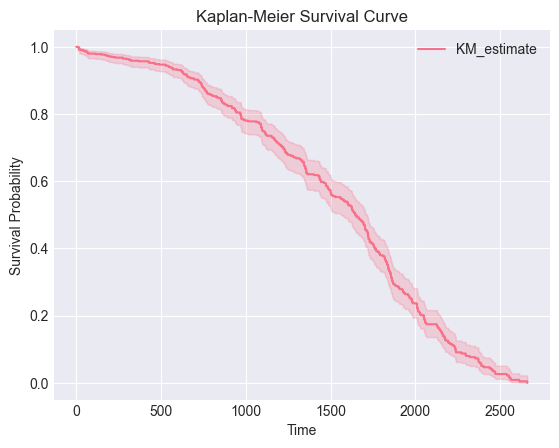


Median survival time: 1645.00


In [56]:
# Fit Kaplan-Meier estimator
# Adjust column names based on your dataset
# Common names: 'T' or 'duration' for time, 'E' or 'event' for event indicator

# Try to auto-detect columns
# time_col = [col for col in df.columns if col == 'T' or 'time' in col.lower() or 'duration' in col.lower()]
# event_col = [col for col in df.columns if col == 'E' or 'event' in col.lower()]
time_col = 'time'
event_col = 'event'

print(f"Using time column: {time_col}")
print(f"Using event column: {event_col}")

kmf = KaplanMeierFitter()
kmf.fit(df[time_col], event_observed=df[event_col])

# Plot survival curve
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

# Print median survival time
median_survival = kmf.median_survival_time_
print(f"\nMedian survival time: {median_survival:.2f}")


## 4. Cox Proportional Hazards Model

The Cox model is a semi-parametric model that can incorporate covariates to predict survival.


In [57]:
df.head()

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens,event
0,no,70,Post,21,II,3,48,66,1814,1,0
1,yes,56,Post,12,II,7,61,77,2018,1,0
2,yes,58,Post,35,II,9,52,271,712,1,0
3,yes,59,Post,17,II,4,60,29,1807,1,0
4,no,73,Post,35,II,1,26,65,772,1,0


In [58]:
def preprocess_data(df):
    data = df.dropna()
    # Convert categorical columns to one-hot encoding
    for col in data.select_dtypes(include=['object', 'category']).columns:
        dummies = pd.get_dummies(data[col], prefix=col, drop_first=True)
        data = pd.concat([data.drop(columns=[col]), dummies], axis=1)
    return data

In [59]:
# Prepare data for Cox model
# Identify which columns are covariates (not time or event)
cens_col = 'cens'
covariate_cols = [col for col in df.columns if col not in [time_col, event_col, cens_col]]

print(f"Covariates to use: {covariate_cols}")

# Fit Cox Proportional Hazards model
cph = CoxPHFitter()

# Create a dataframe with time, event, and covariates
model_df = preprocess_data(df)


# Standardize numerical columns (except time and event columns)
numerical_cols = model_df.select_dtypes(include=['int64', 'float64']).columns
# Exclude duration and event columns from standardization
numerical_cols = [col for col in numerical_cols if col not in [time_col, event_col, cens_col]]

scaler = StandardScaler()
model_df[numerical_cols] = scaler.fit_transform(model_df[numerical_cols])



Covariates to use: ['horTh', 'age', 'menostat', 'tsize', 'tgrade', 'pnodes', 'progrec', 'estrec']


In [60]:
model_df = model_df.drop(columns=[cens_col])
cph.fit(model_df, duration_col=time_col, event_col=event_col)

# Print summary
print("\nCox Model Summary:")
cph.print_summary()



Cox Model Summary:


<lifelines.CoxPHFitter: fitted with 686 total observations, 299 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 387
   partial log-likelihood = -2001.28
         time fit was run = 2025-12-15 15:47:33 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
age          -0.08      0.92      0.09           -0.25            0.08                0.78                1.09
tsize         0.01      1.01      0.06           -0.10            0.12                0.91                1.13
pnodes        0.10      1.11      0.07           -0.03            0.24                0.97                1.27
progrec       0.09      1.09      0.06           -0.02            0.20                0.98                1.22
estrec        0.02      1.02      0.06           -0.10            0.14                0.90                1.16
horTh_yes    -0.24      0.78      0.11           -0.46           -0.03                0.63                0.97
menostat_Pre -0.09      0.91      0.16           -0.41            0.22                0.67                1.25
tgrade_II    -0.13      0.88      0.14           -0.41            0.15                0.66                1.16
tgrade_III    0.22      1.24      0.17           -0.12            0.55                0.89                1.73

              cmp to     z    p  -log2(p)
covariate                                
age             0.00 -0.99 0.32      1.64
tsize           0.00  0.25 0.80      0.32
pnodes          0.00  1.48 0.14      2.85
progrec         0.00  1.58 0.11      3.13
estrec          0.00  0.32 0.75      0.42
horTh_yes       0.00 -2.24 0.03      5.32
menostat_Pre    0.00 -0.57 0.57      0.82
tgrade_II       0.00 -0.91 0.36      1.47
tgrade_III      0.00  1.28 0.20      2.31
---
Concordance = 0.55
Partial AIC = 4020.56
log-likelihood ratio test = 18.69 on 9 df
-log2(p) of ll-ratio test = 5.16

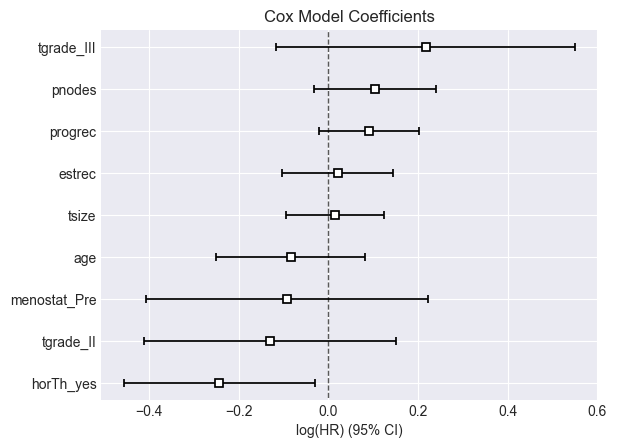

In [61]:
# Visualize coefficients
if len(covariate_cols) > 0:
    cph.plot()
    plt.title('Cox Model Coefficients')
    plt.show()
    
    # Plot partial effects
    if len(covariate_cols) == 1:
        cph.plot_partial_effects_on_outcome(covariates=covariate_cols[0], values=[0, 1] if df[covariate_cols[0]].dtype == 'int64' else None)
        plt.title(f'Partial Effects of {covariate_cols[0]}')
        plt.show()


Survival predictions for sample individuals:
             0         1         2         3         4
8.0   0.998831  0.998891  0.998816  0.998980  0.998898
15.0  0.997662  0.997782  0.997632  0.997959  0.997796
16.0  0.996493  0.996671  0.996446  0.996938  0.996693
17.0  0.994153  0.994450  0.994076  0.994894  0.994486
18.0  0.992981  0.993338  0.992889  0.993870  0.993381


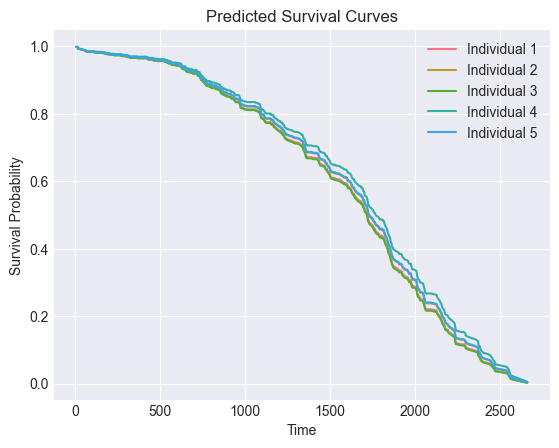

In [62]:
# Predict survival for new data (if covariates exist)
if len(covariate_cols) > 0:
    # Example: predict survival for first few individuals
    sample_data = model_df.iloc[:5].copy()
    sample_data = sample_data.drop(columns=[time_col, event_col])
    
    # Predict survival probabilities at different time points
    survival_predictions = cph.predict_survival_function(sample_data)
    
    print("Survival predictions for sample individuals:")
    print(survival_predictions.head())
    
    # Plot predicted survival curves
    ax = plt.subplot(111)
    for i in range(min(5, len(sample_data))):
        survival_predictions.iloc[:, i].plot(ax=ax, label=f'Individual {i+1}')
    plt.title('Predicted Survival Curves')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.show()


## 5. Model Evaluation

Evaluate the performance of your survival model.


C-index (Concordance): 0.5514
Interpretation: Poor discrimination

Checking proportional hazards assumption...

   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 686 total observations, 299 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic    p  -log2(p)
age          km              5.87 0.02      6.02
             rank            6.33 0.01      6.40
estrec       km              0.12 0.73      0.45
             rank            0.18 0.68      0.57
horTh_yes    km              0.00 0.96      0.07
             rank            0.01 0.93      0.11
menostat_Pre km              2.56 0.11      3.19
             rank            3.20 0.07      3.77
pnodes       km              0.05 0.82      0.29
             rank            0.03 0.86      0.21
progrec      km              0.30 0.58      0.78
             rank            0.24 0.62      0.69
tgrade_II    km              0.00 0.96      0.06
             rank            0.00 1.00      0.00
tgrade_III   km              0.23 0.63      0.66
             rank            0.33 0.57      0.82
tsize        km              0.08 0.78      0.36
             rank            0.00 0.95      0.07



1. Variable 'age' failed the non-proportional test: p-value is 0.0119.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment..

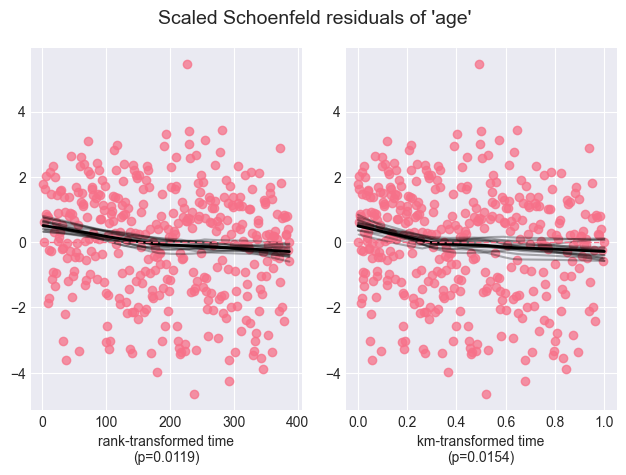

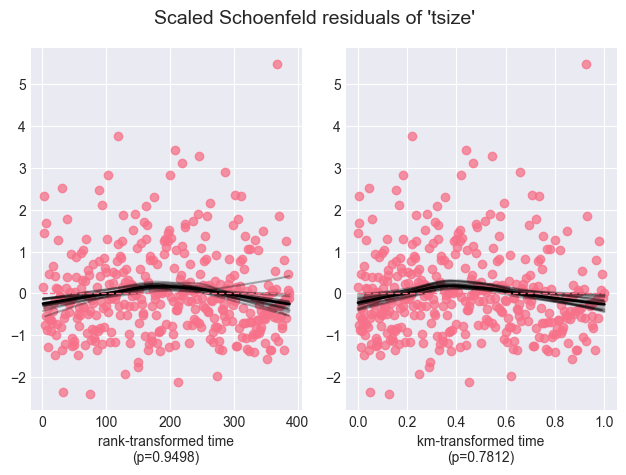

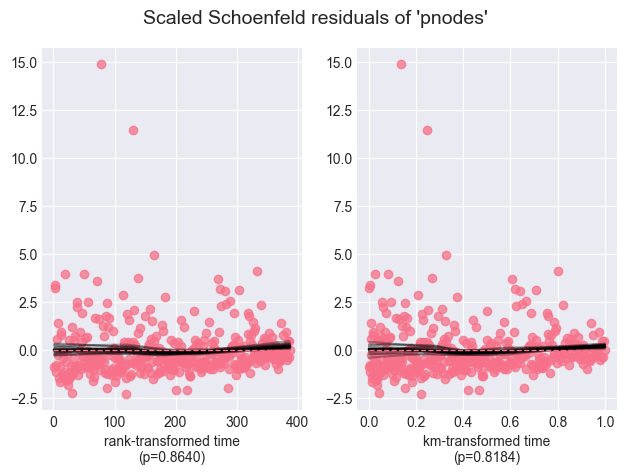

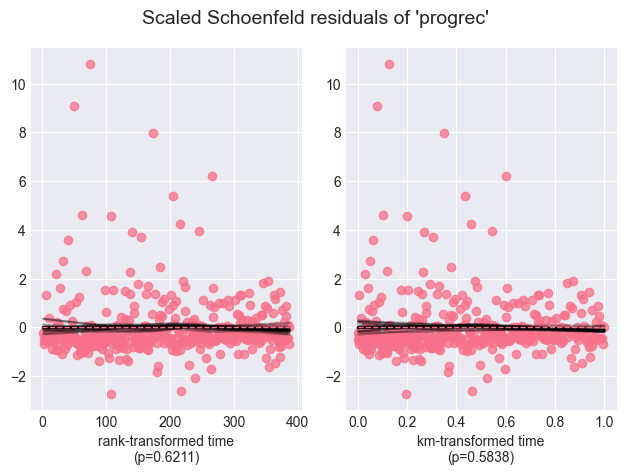

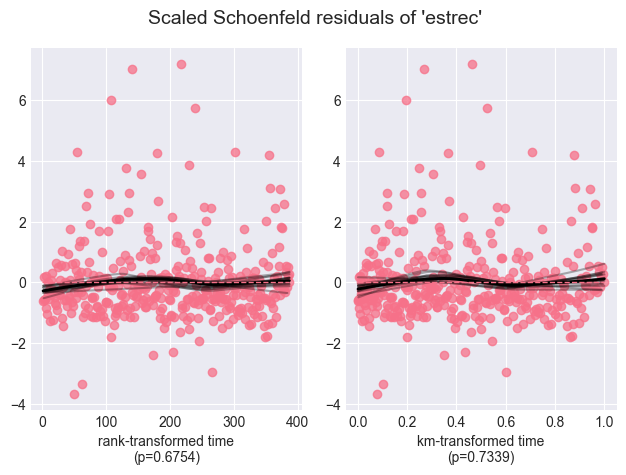

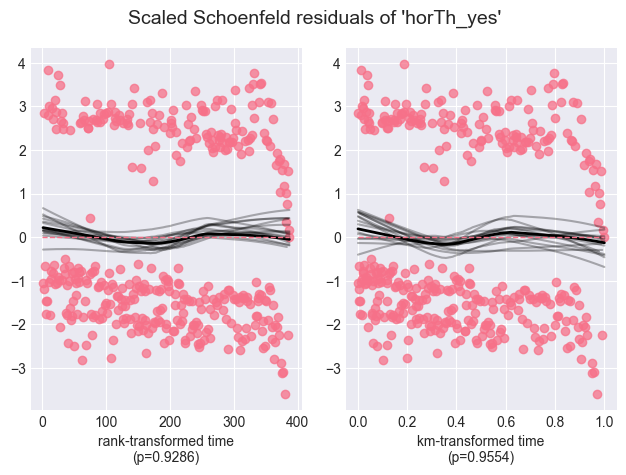

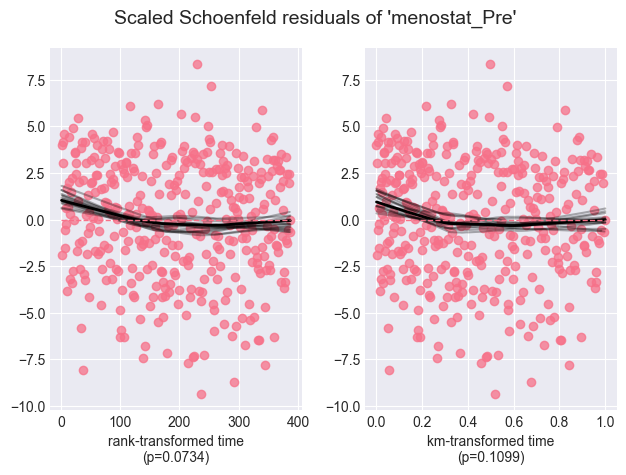

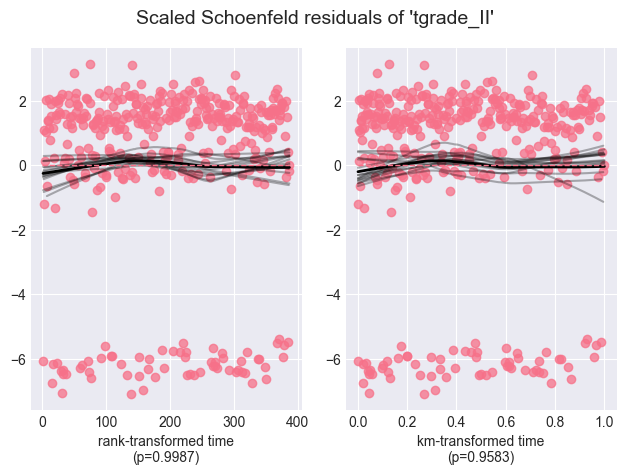

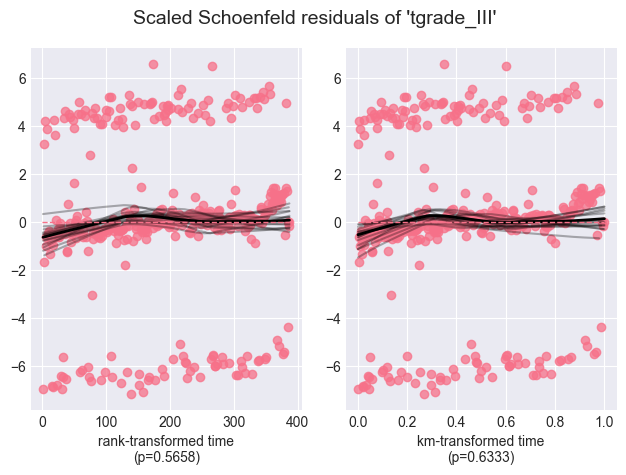

In [63]:
# Concordance index (C-index) - measures model discrimination
# Higher is better (range: 0-1, where 0.5 is random, 1.0 is perfect)
if len(covariate_cols) > 0:
    c_index = cph.concordance_index_
    print(f"C-index (Concordance): {c_index:.4f}")
    print(f"Interpretation: {'Good' if c_index > 0.7 else 'Moderate' if c_index > 0.6 else 'Poor'} discrimination")
    
    # Check proportional hazards assumption
    print("\nChecking proportional hazards assumption...")
    cph.check_assumptions(model_df, p_value_threshold=0.05, show_plots=True)
